# Trined Model Evalution

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/chest-x-ray-diagnosis'

In [2]:
# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from src.utils.utils import plot_auc_curve
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor
from src.weighted_loss.weighted_loss import get_weighted_loss


2025-03-22 07:01:15.141289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742626875.154637   13813 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742626875.158710   13813 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_IMAGES_DIR)

datasets/sample/sample/images


In [4]:
OUPUT_DIR = Path(cfg.OUTPUTS.OUPUT_DIR)

In [5]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

In [6]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [7]:
CLASSES_NAME = ['Atelectasis','Effusion','Infiltration', 'Mass', 'No Finding']

## Loading Data

In [8]:
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor

test_prorcessor  = ChestXRayPreprocessor(cfg, labels=CLASSES_NAME)
_, test_ds, _, _, _= test_prorcessor.get_training_and_validation_datasets()


2025-03-22 07:01:19,495 — src.data_loader.chest_x_ray_preprocessor — INFO — Getting training and validation datasets with batch size:None
2025-03-22 07:01:19,496 — src.data_loader.chest_x_ray_preprocessor — INFO — Loading and preprocessing dataframe
2025-03-22 07:01:19,503 — src.data_loader.chest_x_ray_preprocessor — INFO — Cleaning up training dataframe
2025-03-22 07:01:19,528 — src.data_loader.chest_x_ray_preprocessor — INFO — Loaded dataframe with shape: (5606, 2) and 5606 rows
2025-03-22 07:01:19,547 — src.data_loader.chest_x_ray_preprocessor — INFO — training split: 3947 and validation split: 987
2025-03-22 07:01:19,552 — src.data_loader.chest_x_ray_preprocessor — INFO — Training dataset loaded


I0000 00:00:1742626879.473919   13813 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7547 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2025-03-22 07:01:19,991 — src.data_loader.chest_x_ray_preprocessor — INFO — Augmenting image
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2025-03-22 07:01:21,211 — src.data_loader.chest_x_ray_preprocessor — INFO — Augmenting image
2025-03-22 07:01:21,455 — src.data_loader.chest_x_ray_preprocessor — INFO — Validation dataset loaded
2025-03-22 07:01:22,223 — src.data_

In [9]:
for batch in test_ds.take(1):
    images, labels = batch
    print(images.shape, labels.shape)
    print(images[0].shape, images[0].numpy().min(), images[0].numpy().max(), labels[0])

(32, 512, 512, 3) (32, 5)
(512, 512, 3) -1.0 1.0 tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


## Load the Trained model 

In [10]:
import numpy as np

# Take a batch of images and labels
test_images = []
y_true = []
for image, label in test_ds.unbatch().as_numpy_iterator():
    # for image, label in zip(images, labels):
    test_images.append(image.astype(np.uint8))
    y_true.append(label.astype(int))

y_true = np.array(y_true)
y_true[:10]

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

## Loading keras model

In [11]:

tf_model =  tf.keras.models.load_model('exported_models/my_densenet/checkpoints/best_densenet121.keras',
                                           custom_objects={"get_weighted_loss": get_weighted_loss})

In [12]:
tf_y_pred_prob = tf_model.predict(test_ds)
tf_y_pred_prob[:10]

I0000 00:00:1742627041.299195   13943 cuda_dnn.cc:529] Loaded cuDNN version 90701


31/31 [==============================] - 21s 458ms/step


array([[9.9849897e-03, 2.9520029e-02, 2.9081282e-01, 1.7623566e-01,
        9.3638462e-01],
       [5.8207132e-02, 2.2726849e-01, 4.0410551e-01, 2.3408996e-01,
        7.3070979e-01],
       [2.3829560e-03, 1.0539076e-02, 2.3481949e-01, 1.1310250e-01,
        9.7093832e-01],
       [4.7491145e-01, 6.0657728e-01, 5.4175490e-01, 4.6855435e-01,
        4.0714669e-01],
       [7.6418236e-04, 4.6288744e-03, 2.1056381e-01, 9.3490325e-02,
        9.8402619e-01],
       [2.5151655e-04, 2.7730733e-03, 1.7082083e-01, 5.1212262e-02,
        9.9002588e-01],
       [2.0367265e-01, 3.5654595e-01, 4.5351899e-01, 3.5278910e-01,
        6.1251283e-01],
       [1.7454011e-02, 4.2234309e-02, 3.0827340e-01, 2.0578180e-01,
        9.1683859e-01],
       [6.7898226e-03, 1.9264713e-02, 2.6025936e-01, 1.5223657e-01,
        9.5408344e-01],
       [1.4863684e-03, 6.2181125e-03, 2.0368811e-01, 9.4583042e-02,
        9.8055768e-01]], dtype=float32)

In [13]:
tf_y_pred = (tf_y_pred_prob >= 0.5).astype(int)
tf_y_pred[:10]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [14]:
tf_report = classification_report(y_true,
                    tf_y_pred, 
                    target_names=CLASSES_NAME)
print(tf_report)

              precision    recall  f1-score   support

 Atelectasis       0.13      0.08      0.10       102
    Effusion       0.34      0.49      0.40       129
Infiltration       0.37      0.36      0.36       193
        Mass       0.00      0.00      0.00        57
  No Finding       0.68      0.90      0.78       609

   micro avg       0.56      0.63      0.59      1090
   macro avg       0.30      0.37      0.33      1090
weighted avg       0.50      0.63      0.56      1090
 samples avg       0.62      0.66      0.63      1090



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
y_true[:10], tf_y_pred[:10]

(array([[0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1]]),
 array([[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1]]))

In [16]:
CLASSES_NAME

['Atelectasis', 'Effusion', 'Infiltration', 'Mass', 'No Finding']

In [17]:
tf_cm = multilabel_confusion_matrix(y_true=y_true, 
                                                       y_pred=tf_y_pred)

for i in range(len(CLASSES_NAME)):
    print(f"{CLASSES_NAME[i]}:\n")
    print(tf_cm[i, :, :])
    print("------------")

Atelectasis:

[[831  54]
 [ 94   8]]
------------
Effusion:

[[738 120]
 [ 66  63]]
------------
Infiltration:

[[675 119]
 [124  69]]
------------
Mass:

[[930   0]
 [ 57   0]]
------------
No Finding:

[[124 254]
 [ 60 549]]
------------


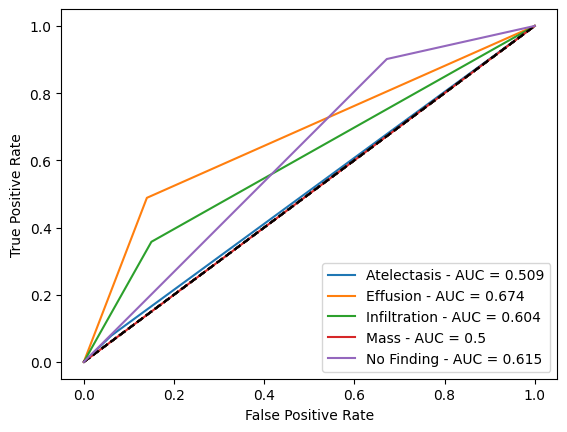

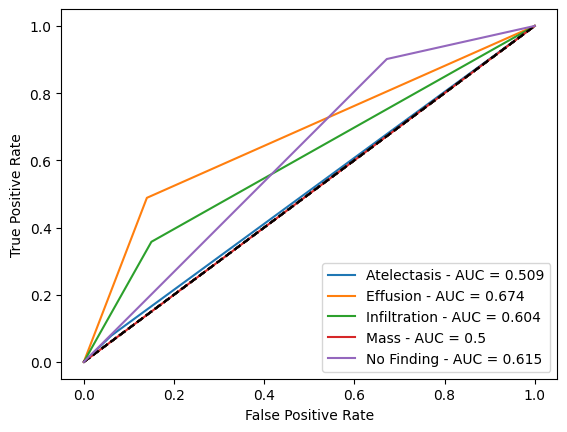

In [18]:
plot_auc_curve(output_dir=OUPUT_DIR, 
                class_name_list=CLASSES_NAME, 
                y_true=y_true, 
                y_prob_pred=tf_y_pred)

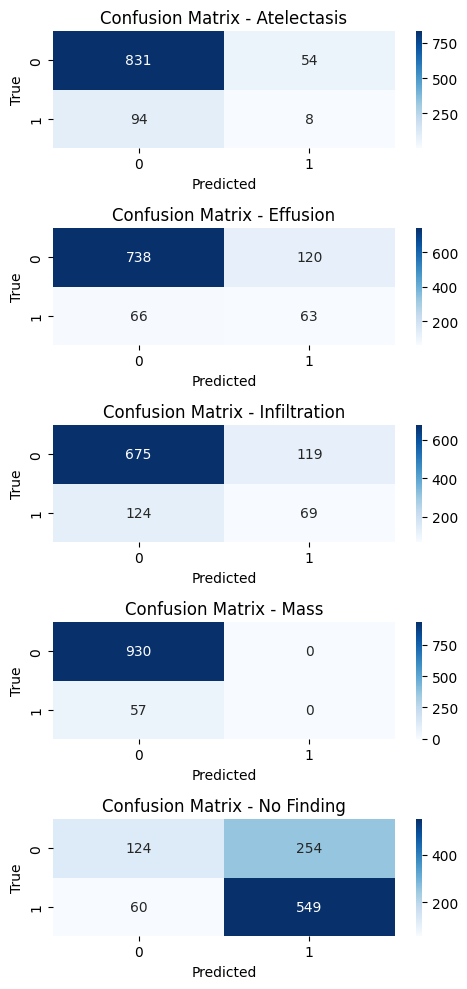

In [19]:
# Multi-label Confusion Matrix
from sklearn.metrics import confusion_matrix

num_classes = len(CLASSES_NAME)
fig, axes = plt.subplots(num_classes,1, figsize=(num_classes, 10))
for i, class_label in enumerate(CLASSES_NAME):
    # cm = confusion_matrix(y_true[:, i], y_pred_pyfunc[:, i])
    sns.heatmap(tf_cm[i, :, :], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix - {class_label}')

plt.tight_layout()
plt.show()
plt.close(fig)

In [20]:
def plot_random_images(test_images, test_labels, num_images=9):
  """
  Plots a random sample of images and their corresponding labels from a TensorFlow dataset.

  Args:
    train_ds: A TensorFlow dataset object containing image-label pairs.
    num_images: The number of images to plot (default: 9).
  """

  # Create a figure and axes for the plot
  plt.figure(figsize=(10, 10))

  # Iterate through the images and plot them
  for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1) # Create a grid of subplots
    plt.imshow(test_images[i], cmap='gray') # Cmultilabel_confusion_matrix
    if len(pred_indices) == 0:
       class_names='None'
    else:
      class_names = '-'.join([CLASSES_NAME[i] for i in pred_indices])
    plt.title(f"{class_names}") # Display the label
    plt.axis("off") # Hide the axes

  plt.tight_layout()
  plt.show()

NameError: name 'pred_indices' is not defined

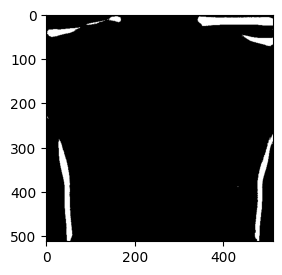

In [21]:
plot_random_images(test_images, y_true, num_images=9)

## Load mlflow model

In [ ]:
model_uri = 'runs:/e5def0441cba4ae3b31f4629364d9d2e/model'
# The model is logged with an input example
mlflow_model =mlflow.tensorflow.load_model(model_uri)

In [ ]:
y_pred_pyfunc_prob = mlflow_model.predict(test_ds)
y_pred_pyfunc = (y_pred_pyfunc_prob >= 0.5).astype(np.uint8)
y_pred_pyfunc[:10]

In [ ]:
py_func_report = classification_report(y_true,
                    y_pred_pyfunc, 
                    target_names=CLASSES_NAME)
print(py_func_report)

In [ ]:
plot_auc_curve(output_dir=OUPUT_DIR, 
                class_name_list=CLASSES_NAME, 
                y_true=y_true, 
                y_prob_pred=y_pred_pyfunc)

In [ ]:
fig, ax = plt.subplots(figsize=(8,25), ncols=2, nrows=8)

for idx in range(8):
    test_image = test_images[idx]
    _y_true = y_true[idx]
    print(_y_true)
    y_pred = y_pred_pyfunc[idx]
    y_true_labels = np.where(_y_true==1)[0]
    y_true_class_name = [CLASSES_NAME[i] for i in y_true_labels]
    if len(y_true_labels) == 0:
        title = '-'
    else : 
        title = '-'.join(y_true_class_name)
    #idx = idx//2
    ax[idx,0].imshow(test_image)
    ax[idx,0].set_title('Ground Truth : {}'.format(title))
    ax[idx,0].axis('off')
    ax[idx,1].barh(CLASSES_NAME, y_pred)
    ax[idx,1].set_yticks(CLASSES_NAME)
    ax[idx,1].set_yticklabels(CLASSES_NAME)
    ax[idx,1].set_title('Predicted Class')
    ax[idx,1].set_xlim(0, 1.1)

plt.tight_layout()
plt.show()

In [ ]:
plot_auc_curve(output_dir='resources', 
               class_name_list=CLASSES_NAME, 
               y_true=y_true, 
               y_prob_pred=y_pred_pyfunc)